In [89]:
import os
import scipy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

In [90]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

#api = KaggleApi()
#api.authenticate()

#output_dir = 'source/' 

#api.dataset_download_files('asaniczka/uk-optimal-product-price-prediction', path=output_dir, unzip=True)

## Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

**Objective**: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

**Dataset**: This lab utilizes the [Amazon UK product dataset](https://www.kaggle.com/datasets/asaniczka/uk-optimal-product-price-prediction/)
which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.

In [91]:
df = pd.read_csv("source/amz_uk_price_prediction_dataset.csv")


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

isBestSeller,False,True,ratio
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
...,...,...,...
Bedding Collections,6309,0,0.000000
CPUs,249,0,0.000000
"CD, Disc & Tape Players",8798,0,0.000000


P-value : 0.0 is below 0.05, meaning there's a significant association between categories and best-seller. As such, we procede with Cramér's test.
 Cramer's V is: 0.1222829439760564, meaning there's a weak association between the variables


<Axes: xlabel='category'>

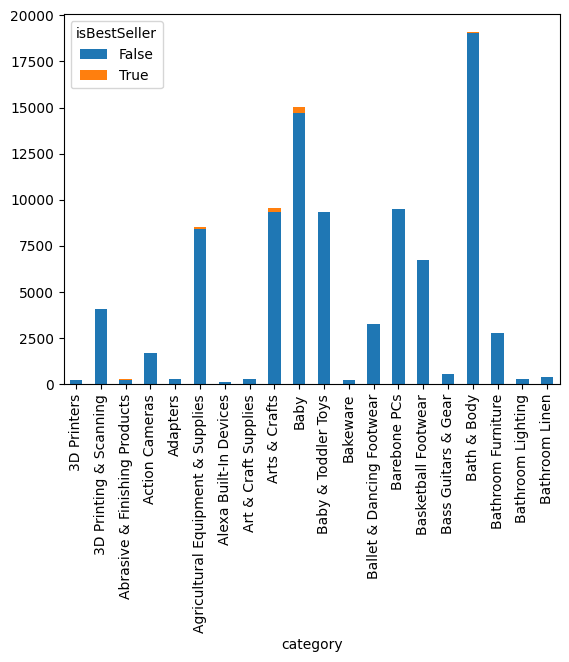

In [92]:
df.head(5)

# Generating a crosstab for 'category' and 'isBestSeller'
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])

column_False = crosstab_result[False]
column_True = crosstab_result[True]

crosstab_result["ratio"] = column_True / (column_True + column_False)

display(crosstab_result.sort_values(by="ratio", ascending = False))

# Crossing categories and best-seller status, we can see some categories that seem to have an higher ratio of BestSellers. Categories such as < Grocery >, < Smart Home > or < Health > seem to show
# a ratio of best sellers around 5%. 

# ChiSquared tests the independence of two categorical variables by comparing observed frequencies to expected frequencies.
# If p-value < 0.05 -> there is a significant association between the categorical variables.

# H0 : category and best seller are independent
# H1 : category and best seller are NOT independent

# testing for equality:
alpha = 0.05
crosstab_result = crosstab_result.drop("ratio", axis=1)

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

p_val = round(float(chi2_p_value),5)
if p_val < alpha:
    print(f"P-value : {p_val} is below {alpha}, meaning there's a significant association between categories and best-seller. As such, we procede with Cramér's test.")
    
    # Cramer's test measures the strength of the association between variables
    cramers = association(crosstab_result, method="cramer")
    if cramers == 0:
        print(f" Cramer's V is: {cramers}, meaning there's no association between the variables")
    elif cramers < 0.2:
        print(f" Cramer's V is: {cramers}, meaning there's a weak association between the variables")
    elif cramers < 0.6:
        print(f" Cramer's V is: {cramers}, meaning there's a moderate association between the variables")
    else:
        print(f" Cramer's V is: {cramers}, meaning there's a strong association between the variables")
    
else:
    print(f"P-value : {p_val} is above or equal to {alpha}, meaning there's no significant association between categories and best-seller")
    
crosstab_result.head(20).plot(kind="bar", stacked=True)

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.


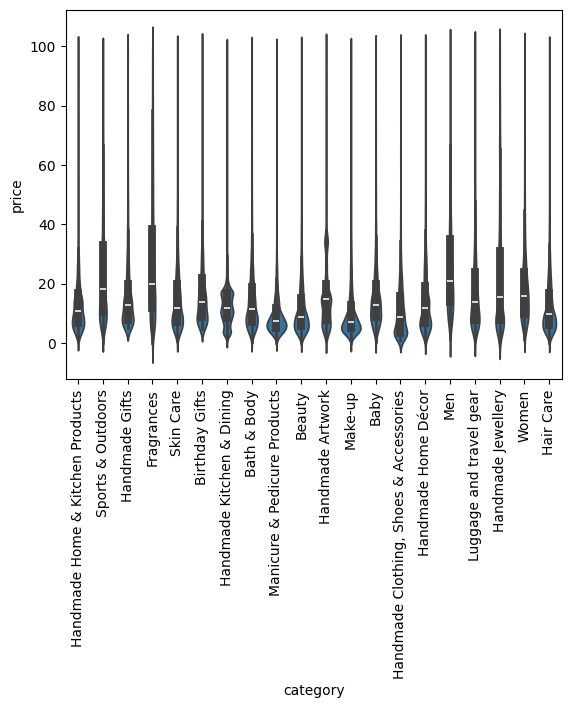

category
Desktop PCs       74.00
Boxing Shoes      69.79
Tablets           69.00
Graphics Cards    68.54
Motherboards      67.92
Name: price, dtype: float64

In [93]:
def tukeys_test_outliers(data, method="show"):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    if method== "show":
        return outliers
    
    elif method == "replace":
        median = data.median()
        data[outliers.index] = median
        return data
        
    elif method == "delete":
        index_drop = outliers.index
        data_no_outliers = data.drop(index_drop)
        
        return data_no_outliers
    
df_t = df.groupby("category")["price"].count().sort_values(ascending = False).head(20).index.to_list()

df["price"] = tukeys_test_outliers(df["price"], method="delete")

df_f = df[df["category"].isin(df_t)]

sns.violinplot(data=df_f, x='category', y='price')
plt.xticks(rotation=90)
plt.show()

df_median = df.groupby("category")["price"].median().sort_values(ascending = False).head(5)
display(df_median)

Highest median seems to be < Desktop PC's > category.

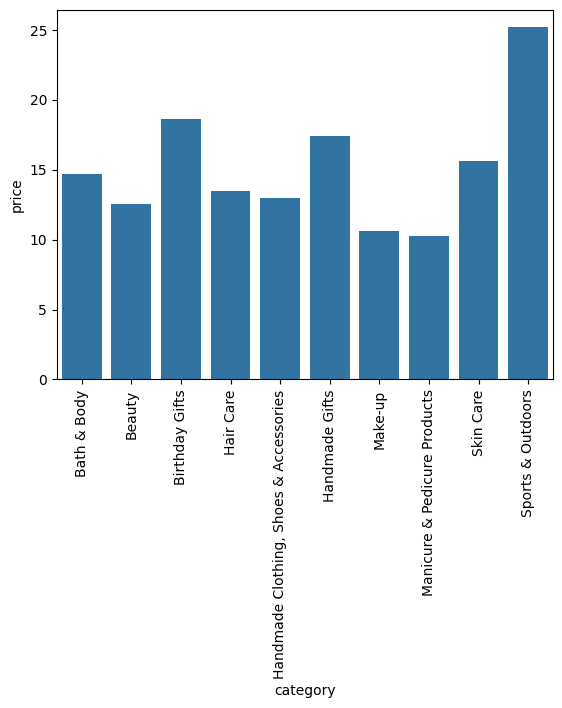

,category,price
190,Motherboards,68.772432


In [94]:
df_t10c = df.groupby("category")["price"].count().sort_values(ascending = False).head(10).index.to_list()
df_price_mean = df.groupby("category")["price"].mean().reset_index()

df_f_t10c = df_price_mean[df_price_mean["category"].isin(df_t10c)]
df_price_mean

sns.barplot(df_f_t10c, x = "category", y = "price")
plt.xticks(rotation=90)
plt.show()

df_price_mean.sort_values(by="price",ascending=False).head(1)

Highest average price is < Motherboards > with a mean of 68.77 .


3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

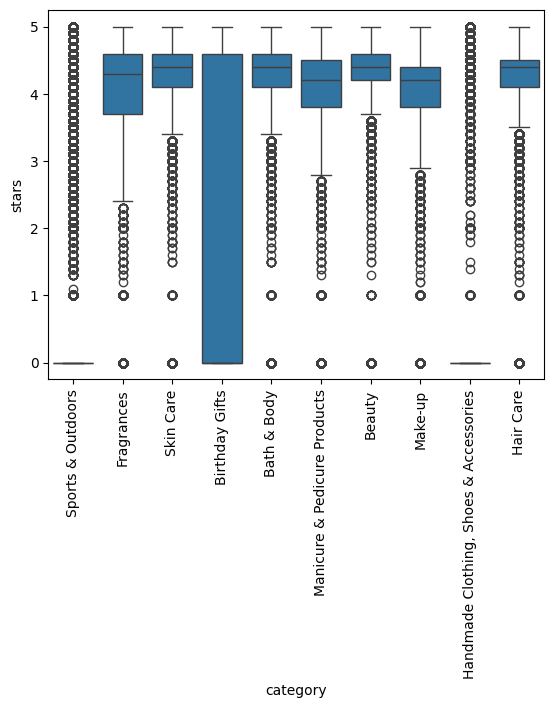

,category,stars
56,Computer Memory,4.7
39,CPUs,4.6
36,Building & Construction Toys,4.6
164,Laptop Accessories,4.6
132,Hobbies,4.6
...,...,...
271,"Synthesisers, Samplers & Digital Instruments",0.0
274,Tablets,0.0
3,Action Cameras,0.0
1,3D Printing & Scanning,0.0


In [95]:
df_s10c = df.groupby("category")["stars"].count().sort_values(ascending = False).head(10).index.to_list()
df_stars_median = df.groupby("category")["stars"].median().reset_index().sort_values(by="stars", ascending= False)

df_f_s10c = df[df["category"].isin(df_s10c)]

sns.boxplot(data=df_f_s10c, x='category', y='stars')
plt.xticks(rotation=90)
plt.show()

display(df_stars_median)

Highest median is seen on < Computer Memory > category, followed by < CPUs >, < Building and construction toys>.

### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?
	
2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 

In [96]:
df_no_outliers = df.copy()
df = pd.read_csv("source/amz_uk_price_prediction_dataset.csv")

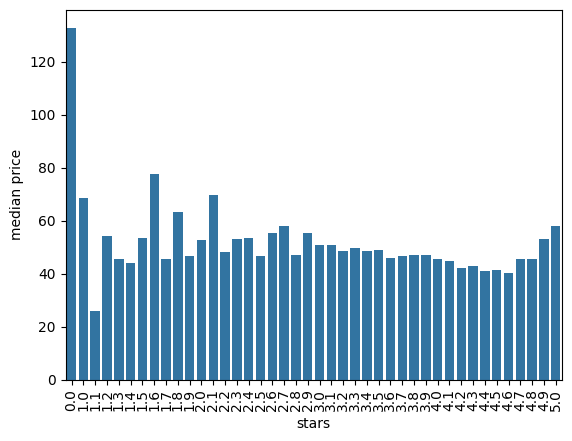

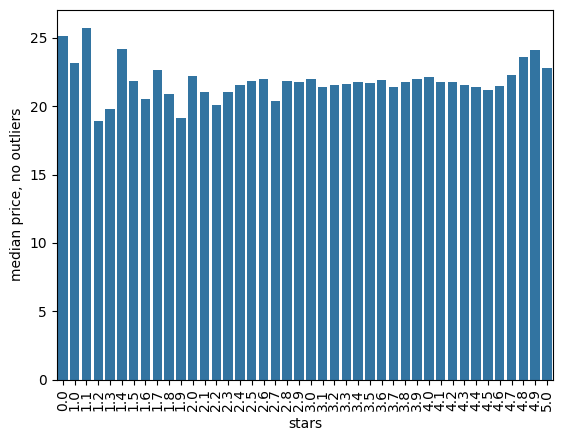

In [97]:
df_s10m = df.groupby("stars")["price"].mean().reset_index().sort_values(by="stars", ascending = False)
df_s10m_no = df_no_outliers.groupby("stars")["price"].mean().reset_index().sort_values(by="stars", ascending = False)
df_s10m


sns.barplot(df_s10m, x = "stars", y = "price")
plt.ylabel("median price")
plt.xticks(rotation=90)
plt.show()

sns.barplot(df_s10m_no, x = "stars", y = "price")
plt.ylabel("median price, no outliers")
plt.xticks(rotation=90)
plt.show()


In [104]:
# correlation with outliers
correlation_p = df['price'].corr(df['stars'])
correlation_s = df['price'].corr(df['stars'], method='spearman')
print(f"Pearson: {correlation_p} || Spearman: {correlation_s} with outliers.")

# correlation without outliers
correlation_p2 = df_no_outliers['price'].corr(df_no_outliers['stars'])
correlation_s2 = df_no_outliers['price'].corr(df_no_outliers['stars'], method='spearman')
print(f"Pearson: {correlation_p2} || Spearman: {correlation_s2} with no outliers.")

Pearson: -0.12490673262148386 || Spearman: -0.13316425462433876 with outliers.
Pearson: -0.07767299878181444 || Spearman: -0.06679697280768455 with no outliers.


With outliers : Pearson: -0.12490673262148386 || Spearman: -0.13316425462433876.

W/o Outliers: Pearson: -0.07767299878181444 || Spearman: -0.06679697280768455.

Both Pearson and Spearman correlations show no apparent correlation between price and ratings.

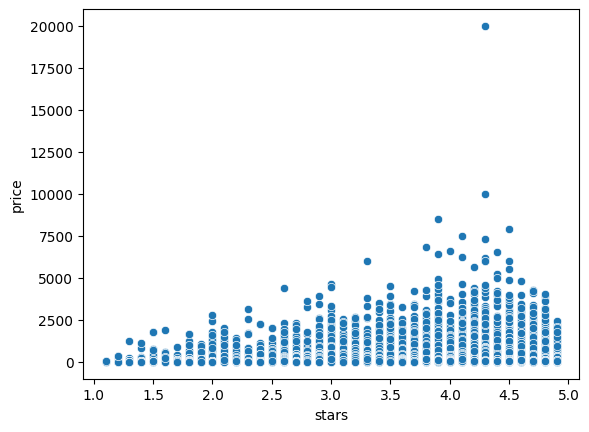

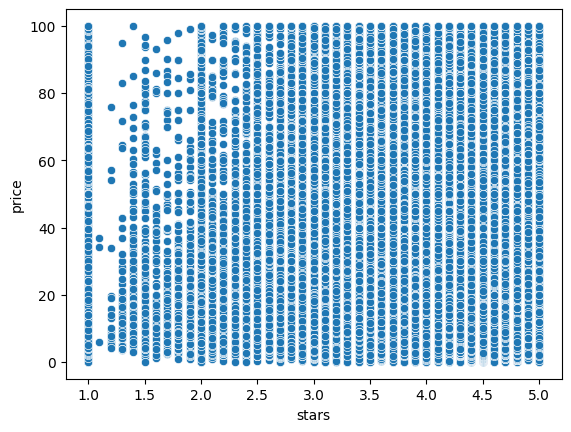

In [108]:
#outliers
df_excl = df[(df["stars"] > 1) & (df["stars"] < 5)] 

sns.scatterplot(df_excl, x = "stars", y='price')
plt.show()

#no outliers
df_excl2 = df_no_outliers[df_no_outliers["stars"] > 0] 

sns.scatterplot(df_excl2, x = "stars", y='price')
plt.show()

Scatterplot shows no apparent correlation between prices and ratings. Even excluding 0 rating, we can still see a distribution that has heavy spread across the rating. If we also exclude the top and bottom rating range(rating 1 and rating 5), then we see the higher prices hover around 4.3 on a negative skewed distribution with strong left tail.

In [112]:
# Adjusting the numerical dataframe by removing the moved columns
df_numerical = df.select_dtypes("number")
df_numerical_no = df_no_outliers.select_dtypes("number")

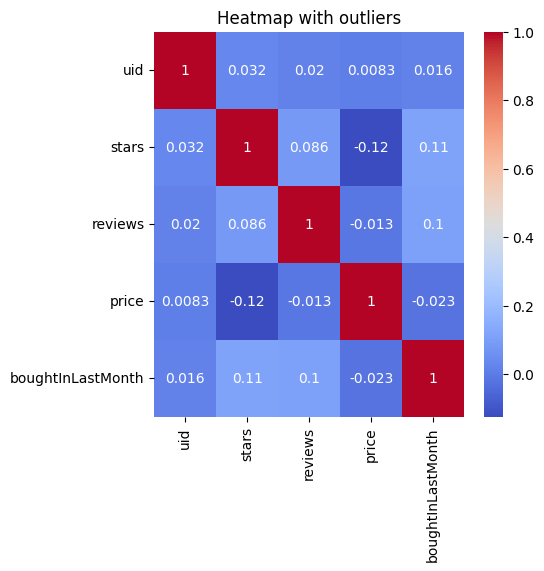

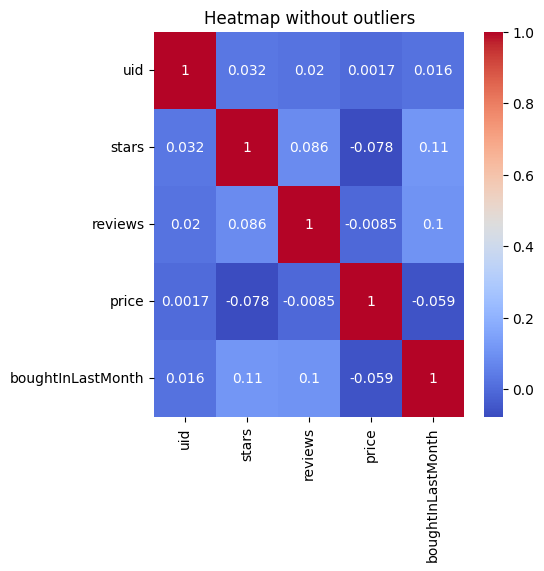

In [113]:
correlation_matrix = df_numerical.corr()
correlation_matrix2 = df_numerical_no.corr()


plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Heatmap with outliers")
plt.show()

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix2, annot=True, cmap="coolwarm")
plt.title("Heatmap without outliers")
plt.show()

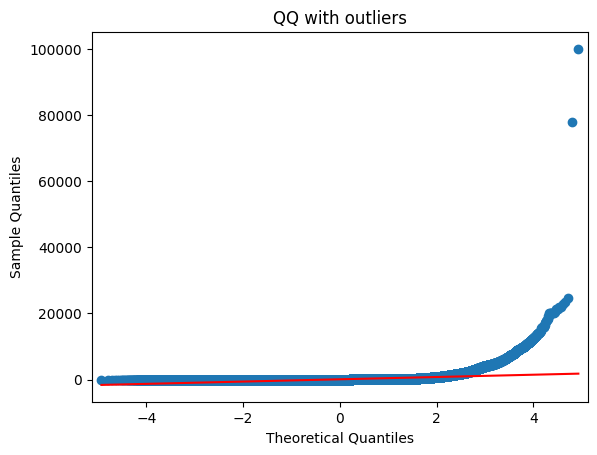

In [116]:
import statsmodels.api as sm

sm.qqplot(df['price'], line='s')
plt.title("QQ with outliers")
plt.show()

Using QQPlot, we see the sample with outliers seems to follow the normal distribution for some point, showing skewness on the right side of the sample.